# March madness tournament predictions
In this kernel we visualized selected features for possible correlation to a winning outcome. We compared and visualized a linear regression, logistic regression, support vector classification and a decision tree with respect to the number of features used and their accuracies on the tournament outcome. Furthermore, we found that over the 2003 to 2018 seasons the data was noisy and fluctuated. In conclusion, we deduced that features matter more then specific models in improving the overall accuracy at the early stages.

In [1]:
# Import libraries needed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import os

## Feature selection 
## stats.NBA.com emphasizes Four Factors as predictors for winning a NBA game   <br> [Why are the Four factos important?](https://stats.nba.com/help/faq/)
 (introduced by Oliver Dean)
- __eFG%:__ effective field goal percentage
- __TOVR:__ turnover ratio
- __OR%:__ offensive rebound percentage
- __FTAR:__ free throw attempt rate

We have included 3 more factors:
<font color='red'>+</font> __DR%:__ defensive rebound percentage
<font color='red'>+</font> __TDR%:__ total defensive rebound percentage
<font color='red'>+</font> __PIE:__ player impact estimate

“High PIE% is highly correlated to winning. In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation.” – [stats.nba.com](https://stats.nba.com/)


#### Calculating the PIE
What is PIE?
It is a simple metric that gives an excellent indication of performance at both the team and player level. It’s a major improvement to our EFF Rating. Notably 2 things changed: (1) We included Personal Fouls, (2) We added a denominator. We feel the key here is the denominator because it acts as an "automatic equalizer". Using the denominator, we find there is no need to consider the "PACE" of the statistics that are being analyzed. In its simplest terms, PIE shows what % of game events did that player or team achieve. The stats being analyzed are your traditional basketball statistics (PTS, REB, AST, TOV, etc..) A team that achieves more than 50% is likely to be a winning team. A player that achieves more than 10% is likely to be better than the average player. A high PIE % is highly correlated to winning. In fact, a team’s PIE rating and a team’s winning percentage correlate at an R square of .908 which indicates a "strong" correlation. We’ve introduced this statistic because we feel it incorporates a bit of defense into the equation. When a team misses a shot, all 5 players on the other team’s PIE rating goes up. The formula for PIE can be found here in the Glossary.
Source: [What is PIE?](https://stats.nba.com/help/faq/)
<br>
Formula: (PTS + FGM + FTM - FGA - FTA + DREB + (.5 * OREB) + AST + STL + (.5 * BLK) - PF - TO) / (GmPTS + GmFGM + GmFTM - GmFGA - GmFTA + GmDREB + (.5 * GmOREB) + GmAST + GmSTL + (.5 * GmBLK) - GmPF - GmTO)

In [2]:
#from subprocess import check_output
#print(check_output(["ls", "../input/mens-machine-learning-competition-2019"]).decode("utf8"))

In [3]:
def load_and_construct_features_in_df(year):
    """
    Input: year: Season year, e.g. 2017
    Output: df: DataFrame with constructed features that can be used for training a ML model.
    """
    # Read in data
    #directory = 'G:/My Drive/Research Work/7 Kaggle/2019 NCAA/mens-machine-learning-competition-2019/DataFiles/'
    directory = os.getcwd().replace('\\','/')
    df_teams_seeds = pd.read_csv('../input/mens-machine-learning-competition-2019/datafiles/NCAATourneySeeds.csv').query('Season =='+str(year))

    # Strip letters in seed column an return an integer
    df_teams_seeds['Seed'] = df_teams_seeds['Seed'].apply(lambda x: int(x[1:3]))
    #print df_teams_seeds.head()

    df_tournament_results = pd.read_csv('../input/mens-machine-learning-competition-2019/datafiles/RegularSeasonDetailedResults.csv').query('Season=='+str(year))
    #print df_tournament_results.head()

    #Add 'WSeed','LSeed' feature to Detailed Tournament list by merging with renamed lists
    # and calculate SeedDifference and add as a feature to df_final
    df_renamed_win = df_teams_seeds.rename(columns={'TeamID':'WTeamID','Seed':'WSeed'})
    df_renamed_loss = df_teams_seeds.rename(columns={'TeamID':'LTeamID','Seed':'LSeed'})
    df_mixed = df_tournament_results.merge(df_renamed_win, how='left', on=['Season','WTeamID'])
    df_final = df_mixed.merge(df_renamed_loss, how='left', on=['Season','LTeamID'])
    
    ### FEATURE CONSTRUCTION STARTS HERE ###
    df_final['SeedDifference'] = df_final['WSeed'] - df_final['LSeed'] 
    df_final['ScoreDifference'] = df_final['WScore'] - df_final['LScore'] 
    #df_final.head()

    # DTOVR (Difference in 'Turnover Ratio'): 100 * TOV / (FGA + (0.44 * FTA) + AST + TOV)
    df_final['WTOVR'] = 100* df_final['WTO']/(df_final['WFGA'] + (0.44*df_final['WFTA']) + df_final['WAst'] + df_final['WTO'])
    df_final['LTOVR'] = 100* df_final['LTO']/(df_final['LFGA'] + (0.44*df_final['LFTA']) + df_final['LAst'] + df_final['LTO'])
    df_final['DTOVR'] = df_final['WTOVR'] - df_final['LTOVR']
    # DeFG% (Difference in 'effective FieldGoal percentage'):  (FGM + 0.5 * 3PM) / FGA.
    df_final['WeFG%'] = (df_final['WFGM'] + 0.5*df_final['WFGM3'])/(df_final['WFGA'] + df_final['WFGA3'])
    df_final['LeFG%'] = (df_final['LFGM'] + 0.5*df_final['LFGM3'])/(df_final['LFGA'] + df_final['LFGA3'])
    df_final['DeFG%'] = df_final['WeFG%'] - df_final['LeFG%']

    #df_final['DeFG%'].describe()
    # DFTAR (Difference in 'FreeThrow Attempt rate'):  FTA / FGA.
    df_final['WFTAR'] = df_final['WFTA']/df_final['WFGA']
    df_final['LFTAR'] = df_final['LFTA']/df_final['LFGA']
    df_final['DFTAR'] = df_final['WFTAR'] - df_final['LFTAR']
    # DOR% (Difference in 'Offensive rebound %'):  WOR / LDR+WOR. Notice that we divide by the 
    # a) number of OffensiveRebounds + number of OpponentsDefensiveRebounds (We look at one side of the board).
    df_final['WOR%'] = df_final['WOR']/(df_final['LDR'] + df_final['WOR'])
    df_final['LOR%'] = df_final['LOR']/(df_final['LOR'] + df_final['WDR'])
    df_final['DOR%'] = df_final['WOR%'] - df_final['LOR%']
    # b) DDR% (Difference in 'Defensive rebound %'):  WDR / LOR+WDR.
    df_final['WDR%'] = df_final['WDR']/(df_final['LOR'] + df_final['WDR'])
    df_final['LDR%'] = df_final['LDR']/(df_final['LDR'] + df_final['WOR'])
    df_final['DDR%'] = df_final['WDR%'] - df_final['LDR%']
    # c) DTDR% (Difference in 'Total Defensive rebound %'):  WDR / LDR+WDR.
    df_final['WTDR%'] = df_final['WDR']/(df_final['LDR'] + df_final['WDR'])
    df_final['LTDR%'] = df_final['LDR']/(df_final['LDR'] + df_final['WDR'])
    df_final['DTDR%'] = df_final['WTDR%'] - df_final['LTDR%']
    # d)
    df_final['WTOR%'] = df_final['WOR']/(df_final['LOR'] + df_final['WOR'])
    df_final['LTOR%'] = df_final['LOR']/(df_final['LOR'] + df_final['WOR'])
    df_final['DTOR%'] = df_final['WTOR%'] - df_final['LTOR%']
    # Adding PIE value to df_final
    df_final['WPIE'] = (df_final['WScore'] + df_final['WFGM'] + df_final['WFTM'] - df_final['WFGA'] 
                        - df_final['WFTA'] + df_final['WDR'] + (0.5*df_final['WOR']) + df_final['WAst'] 
                        + df_final['WStl'] + (0.5*df_final['WBlk']) - df_final['WPF'] - df_final['WTO']
                        )/(
                        df_final['WScore'] + df_final['LScore'] + df_final['WFGM'] + df_final['LFGM'] 
                        + df_final['WFTM'] + df_final['LFTM'] - df_final['WFGA'] - df_final['LFGA'] 
                        + df_final['WDR'] + df_final['LDR'] + (0.5*df_final['WOR'] + 0.5*df_final['LOR']) 
                        + df_final['WAst'] + df_final['LAst'] + df_final['WStl'] + df_final['LStl'] 
                        + (0.5*df_final['WBlk'] + 0.5*df_final['LBlk']) - df_final['WPF'] - df_final['LPF']
                        - df_final['WTO'] - df_final['WTO']
                        )

    df_final['LPIE'] = (df_final['LScore'] + df_final['LFGM'] + df_final['LFTM'] - df_final['LFGA']
                     - df_final['LFTA'] + df_final['LDR'] + (0.5*df_final['LOR']) + df_final['LAst']
                     + df_final['LStl'] + (0.5*df_final['LBlk']) - df_final['LPF'] - df_final['LTO']
                     )/(
                     df_final['WScore'] + df_final['LScore'] + df_final['WFGM'] + df_final['LFGM'] 
                     + df_final['WFTM'] + df_final['LFTM'] - df_final['WFGA'] - df_final['LFGA'] 
                     + df_final['WDR'] + df_final['LDR'] + (0.5*df_final['WOR'] + 0.5*df_final['LOR']) 
                     + df_final['WAst'] + df_final['LAst'] + df_final['WStl'] + df_final['LStl'] 
                     + (0.5*df_final['WBlk'] + 0.5*df_final['LBlk'])  - df_final['WPF'] - df_final['LPF']
                     - df_final['WTO'] - df_final['WTO']
                     )
    df_final['DPIE'] = df_final['WPIE'] - df_final['LPIE']
    return df_final
df_final = load_and_construct_features_in_df(year=2016)
df_final.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,WSeed,LSeed,SeedDifference,ScoreDifference,WTOVR,LTOVR,DTOVR,WeFG%,LeFG%,DeFG%,WFTAR,LFTAR,DFTAR,WOR%,LOR%,DOR%,WDR%,LDR%,DDR%,WTDR%,LTDR%,DTDR%,WTOR%,LTOR%,DTOR%,WPIE,LPIE,DPIE
0,2016,11,1104,77,1244,64,H,0,29,57,4,17,15,27,10,28,13,12,11,6,21,19,55,7,19,19,26,12,27,6,16,7,4,25,NaN,NaN,NaN,13,12.782275,18.091361,-5.309086,0.418919,0.304054,0.114865,0.473684,0.472727,0.000957,0.270270,0.300000,-0.029730,0.700000,0.729730,-0.029730,0.509091,0.490909,0.018182,0.454545,0.545455,-0.090909,0.429530,0.187919,0.241611
1,2016,11,1105,68,1408,67,A,1,25,64,8,29,10,17,14,23,10,15,12,1,25,22,57,7,27,16,26,18,30,11,19,6,7,21,NaN,NaN,NaN,1,15.547264,19.301097,-3.753833,0.311828,0.303571,0.008257,0.265625,0.456140,-0.190515,0.318182,0.439024,-0.120843,0.560976,0.681818,-0.120843,0.433962,0.566038,-0.132075,0.437500,0.562500,-0.125000,0.280488,0.337398,-0.056911
2,2016,11,1112,79,1334,61,H,0,24,61,6,20,25,32,17,34,12,14,4,6,21,21,57,6,19,13,19,5,23,9,9,3,1,25,6.0,NaN,NaN,18,13.850416,10.796545,3.053870,0.333333,0.315789,0.017544,0.524590,0.333333,0.191257,0.425000,0.128205,0.296795,0.871795,0.575000,0.296795,0.596491,0.403509,0.192982,0.772727,0.227273,0.545455,0.471264,0.176245,0.295019
3,2016,11,1115,58,1370,56,A,0,20,55,7,30,11,16,8,29,12,12,8,6,23,17,49,6,16,16,28,10,31,12,15,5,0,17,NaN,NaN,NaN,2,13.947001,16.983696,-3.036694,0.276471,0.307692,-0.031222,0.290909,0.571429,-0.280519,0.205128,0.256410,-0.051282,0.743590,0.794872,-0.051282,0.483333,0.516667,-0.033333,0.444444,0.555556,-0.111111,0.327731,0.277311,0.050420
4,2016,11,1116,86,1380,68,H,0,32,66,8,15,14,26,17,26,21,14,10,6,24,22,53,4,12,20,28,7,21,9,17,8,5,22,NaN,16.0,NaN,18,12.451085,18.615856,-6.164771,0.444444,0.369231,0.075214,0.393939,0.528302,-0.134362,0.447368,0.212121,0.235247,0.787879,0.552632,0.235247,0.553191,0.446809,0.106383,0.708333,0.291667,0.416667,0.436533,0.210526,0.226006


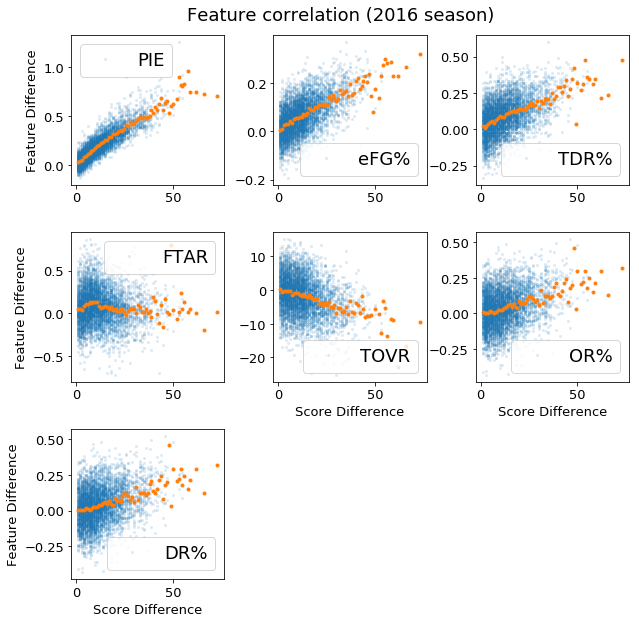

In [4]:
# Plot Correlations of features
import matplotlib.gridspec as gridspec
features = ['DPIE','DeFG%','DTDR%','DFTAR','DTOVR','DOR%','DDR%']
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,1,1],
                       hspace=0.32, wspace=0.32)
counter = 0
plt.suptitle('Feature correlation (2016 season)', y=0.92, size= 18)
for feature in features:
    ax = plt.subplot(gs[counter])
    plt.plot(df_final['ScoreDifference'], df_final[feature], marker='.', markerfacecolor = None, markeredgewidth = 0, linestyle='none', zorder= 1, label = feature[1:], alpha = 0.15)
    df_grouped = df_final.groupby(['ScoreDifference']).describe().reset_index()
    plt.plot(df_grouped['ScoreDifference'], df_grouped[feature]['mean'], marker='.', color='C1', linestyle='none', zorder=2, label='')
    if counter in [4,5,6]:
        plt.xlabel('Score Difference', size=13)
    if counter in [0,3,6]:
        plt.ylabel('Feature Difference', size=13)
    plt.legend(fontsize=18)
    plt.tick_params(labelsize=13)
    counter += 1
plt.savefig('FeatureCorrelation.png')

## Check for collinearity

In [5]:
# Extracting training data from the final dataframe of the whole 2016 season
def get_training_data(df_final, columns):
    """
    Input:  df_final: Dataframe with all features that can be used for estimating game results.
            Columns: List of column labels. Column labels must be present in df_final.
    Output: X_train, Y_train datasets, which can be directly fed into the LogReg model
    """
    for feature in columns:
        if feature not in df_final.columns:
            raise Exception('The feature {}'.format(feature)+' is not in the DataFrame. All features must be labels of a column of the dataframe.')
    
    df_wins = pd.DataFrame()
    df_losses = pd.DataFrame()
    for feature in columns:
        df_wins[str(feature)] = df_final[str(feature)]
        df_losses[str(feature)] = -df_final[str(feature)]
    df_wins['Result'] = 1
    df_losses['Result'] = 0

    training_data = pd.concat([df_losses, df_wins], axis=0)

    if len(columns) == 1:
        X_train = training_data[columns].values.reshape(-1,1)
    else:
        X_train = training_data[columns].values
    Y_train = training_data.Result.values
    return (X_train, Y_train)

X_train, Y_train = get_training_data(df_final, columns=['DPIE','DeFG%', 'DOR%','DTDR%','DFTAR','DTOVR'])
corr = np.corrcoef(X_train, rowvar=0)  # correlation matrix
w, v = np.linalg.eig(corr)        # eigen values & eigen vectors
print(w)
#print v
# 'DDR%','DOR%' are collinear. 'DTOR%' and 'DTDR%' are almost collinear.
# 'DPIE','DeFG%', 'DOR%','DTDR%','DFTAR','DTOVR'

[2.87110212 0.04421489 0.10289838 1.19634912 0.98090457 0.80453092]


Result: __Defensive rebound %__ was found to be collinear with the __offensive rebound %__.

## Get training data and setup ML algorithm
What will be the input for my classifier? The PIE value shows the strongest correlation, hence associating the difference of PIE value with 0 or 1 could be one way or the values themself.

In [6]:
# Extracting training data from the final dataframe of the whole 2016 season
X_train, Y_train = get_training_data(df_final, columns=['DOR%', 'DPIE', 'DTOVR', 'DeFG%'])

In [7]:
def train_ML_model(X_train, Y_train, cv, model):
    '''
    Input:  X_train, Y_train: X and Y training data
            cv: Cross-validation integer value
            model: A string of either: 'LinReg','LogReg','DecTree','SVC'.
    Output: GridSearchedObject, ClassifierObject, LogLoss, Regularization Parameter C
    '''
    if model not in ['LinReg','LogReg','DecTree','SVC']:
        raise Exception('Model needs to be LinReg, LogReg, DecTree or SVC')

    X_train, Y_train = shuffle(X_train, Y_train)
    if model == 'LinReg':
        linreg =LinearRegression()
        paramsLinReg = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
        clf = GridSearchCV(linreg, paramsLinReg,cv=cv)
        clf.fit(X_train, Y_train)
        print('Best score: {:.4}'.format(clf.best_score_ ))
        C_dummy = 0
        return clf, linreg, clf.best_score_ , C_dummy
    if model == 'LogReg':
        logreg = LogisticRegression()
        params = {'C': np.logspace(start=-15, stop=15, num=200), 'solver': ['liblinear']} #Parmeter of ML model
        clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True, cv=cv)
        clf.fit(X_train, Y_train)
        print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))
        return clf, logreg, clf.best_score_, clf.best_params_['C']
    if model == 'SVC':
        SVCreg = SVC(probability=True)
        params = {'C': np.logspace(start=-2, stop=3, num=10), 'kernel':['rbf']}
        clf = GridSearchCV(SVCreg, params, scoring='neg_log_loss', refit=True, cv=cv)
        clf.fit(X_train, Y_train)
        print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))
        return clf, SVCreg, clf.best_score_, clf.best_params_['C']
    if model == 'DecTree':
        Tree = DecisionTreeClassifier()
        params = {'max_depth': range(1,8),'min_samples_split': np.arange(2,7),
                  'min_samples_leaf':np.arange(1,5), 'max_features': np.arange(1,X_train.shape[1]+1)} #Parmeter of ML model
        clf = GridSearchCV(Tree, params, scoring='neg_log_loss', refit=True, cv=cv)
        clf.fit(X_train, Y_train)
        print('Best log_loss: {:.4}, with best max_depth: {}, best min_samples_split: {}, min_samples_leaf:{}, max_features_split:{}'.format(clf.best_score_, clf.best_params_['max_depth'], clf.best_params_['min_samples_split'], clf.best_params_['min_samples_leaf'], clf.best_params_['max_features']))
        return clf, Tree, clf.best_score_, clf.best_params_['max_depth']
clf, reg, score, C = train_ML_model(X_train, Y_train, cv=3, model='LogReg')

Best log_loss: -0.1091, with best C: 153.43684089300132


## Make a prediction
#### So now in order to make a prediction I have to take in e.g. the Difference of the Player Impact Estimate (DPIE) of the two teams playing:
There are different options to do this:
- Take the average over every season game (pretournament)
- Take the average over the past 8 games
- Just include previous games of these two team

In [8]:
# At first we will take the average value over every season game
# Load the list that made it to the tournament
def generate_tournament_team_list(year):
    """
    List of teams will be generated that made it into the Tournament.
    Output: List and copy of list.
    """
    df_teams = pd.read_csv('../input/mens-machine-learning-competition-2019/datafiles/NCAATourneyCompactResults.csv').query('Season=='+str(year))
    df_teams = df_teams.sort_values(by=['WTeamID','LTeamID'])
    #print(df_teams)

    a = df_teams.drop_duplicates(subset=['WTeamID'])['WTeamID'] #List of winning teams
    b = df_teams.drop_duplicates(subset=['LTeamID'])['LTeamID'] # List of loosing Teams
    Team_IDs = a.append(b,ignore_index=True).drop_duplicates().values.tolist() # Add both lists and drop duplicates
    Team_IDs_copy = a.append(b,ignore_index=True).drop_duplicates().values.tolist()# List of TeamIDs
    Team_IDs_copy = sorted(Team_IDs_copy)
    Team_IDs = sorted(Team_IDs)
    print ('Number of teams playing in '+str(year)+' Tournament: '+ str(len(Team_IDs))+'/68 (64 + The first four).')
    return Team_IDs, Team_IDs_copy
Team_IDs, Team_IDs_copy = generate_tournament_team_list(year=2017)

def generate_df_for_prediction(df_final, columns, year):
    '''
    Input:  df_dinal: DF that contains features which will be used as estimators. Require 'WTeamID' and 'LTeamID' features.
            columns: List of features that will be averaged. Columns must be contained in df_final
    Output: df with TeamID and averaged feature over the past season.
    '''
    for feature in columns:
        if 'W'+feature not in df_final.columns or 'L'+feature not in df_final.columns:
            raise Exception('The feature {}'.format(feature)+' is not in the DataFrame. All features must be labels of a column of the dataframe.')

    Team_IDs, Team_IDs_copy = generate_tournament_team_list(year)
            
    df_for_prediction = pd.DataFrame(columns=['ID'] + columns)
    counter = 0
    for ID in Team_IDs:
        df_for_prediction.at[counter, 'ID'] = str(ID)
        for feature in columns:
            a = df_final[df_final['WTeamID']==ID]['W'+str(feature)] # Gives a colum of a specific team with the feature called 'feature'.
            b = df_final[df_final['LTeamID']==ID]['L'+str(feature)]
            AVERAGE = a.append(b,ignore_index=True).mean()
            df_for_prediction.at[counter, feature] = AVERAGE
            #df_for_prediction = df_for_prediction.append({'ID':str(ID), str(feature):AVERAGE}, ignore_index=True)
            del a
            del b
            del AVERAGE
        counter += 1
    return df_for_prediction
df_for_prediction = generate_df_for_prediction(df_final, columns=['OR%', 'PIE', 'TOVR', 'eFG%'], year=2016)
df_for_prediction.head()
#df_for_prediction

Number of teams playing in 2017 Tournament: 68/68 (64 + The first four).
Number of teams playing in 2016 Tournament: 68/68 (64 + The first four).


,ID,OR%,PIE,TOVR,eFG%
0,1112,0.345147,0.450142,13.2258,0.420496
1,1114,0.267387,0.427308,12.0852,0.392038
2,1122,0.313898,0.343985,15.4346,0.395195
3,1124,0.397768,0.393503,13.2398,0.404594
4,1138,0.317453,0.347124,14.3933,0.365046


In [9]:
# Make a DF which provides Game_ID and the difference of an indicator/feature, e.g. 'DeFG%'
def generate_prediction_features(df_for_prediction, columns, year):
    """
    Input:  df_for_prediction: Obtained from generate_df_for_prediction(df_final, columns).
            columns: Features containes in df_for_prediction e.g. ['eFG%','PIE']
            year: Seaon year
    Outout: X_Prediction columns
    """
    for feature in columns:
        if feature not in df_for_prediction.columns:
            raise Exception('The feature {}'.format(feature)+' is not in the DataFrame. All features must be labels of a column of the dataframe.')
    # ['eFG%','PIE']
    col = ['ID','Season','Team1','Team2']
    for feature in columns:
        cols = col + [feature+'1'] + [feature+'2'] + ['D'+feature]
    #cols = ['ID','Season','Team1','Team2','eFG%1','eFG%2','DeFG%']
    df_prediction = pd.DataFrame(columns=cols)
    #Tournament list need to be regenerate every time generater predictions is called because the teams are removed from the list
    Team_IDs, Team_IDs_copy = generate_tournament_team_list(year=year)
    print('Number of teams playing in '+str(year)+' Tournnament: '+ str(len(Team_IDs))+'/68 (64 + The first four).')
    dummy_a = Team_IDs
    dummy_b = Team_IDs_copy
    counter = 0
    for ID1 in dummy_a:
        #print ID
        dummy_b.remove(ID1)
        for ID2 in dummy_b:
            Game_ID = str(year)+'_'+str(ID1)+'_'+str(ID2)
            df_prediction.at[counter, 'ID'] = Game_ID # Add Game_ID value to row = counter and cell='ID' 
            df_prediction.at[counter, 'Season'] = year
            df_prediction.at[counter, 'Team1'] = ID1
            df_prediction.at[counter, 'Team2'] = ID2
            for feature in columns:
                dummy_var_a = df_for_prediction[df_for_prediction['ID'] == str(ID1)][str(feature)].values[0]
                dummy_var_b = df_for_prediction[df_for_prediction['ID'] == str(ID2)][str(feature)].values[0]
                df_prediction.at[counter, feature+'1'] = dummy_var_a
                df_prediction.at[counter, feature+'2'] = dummy_var_b
                df_prediction.at[counter, 'D'+feature] = dummy_var_a - dummy_var_b
            counter += 1
    for features in col: # convert values in features column to float values
        df_prediction['D'+feature] = df_prediction['D'+feature].apply(lambda x: float(x))
    #print len(df_prediction)
    return df_prediction
df_pred = generate_prediction_features(df_for_prediction, columns=['OR%', 'PIE', 'TOVR', 'eFG%'], year=2016)
df_pred.head()
#df_pred['DeFG%'].describe()

Number of teams playing in 2016 Tournament: 68/68 (64 + The first four).
Number of teams playing in 2016 Tournnament: 68/68 (64 + The first four).


,ID,Season,Team1,Team2,eFG%1,eFG%2,DeFG%,OR%1,OR%2,DOR%,PIE1,PIE2,DPIE,TOVR1,TOVR2,DTOVR
0,2016_1112_1114,2016,1112,1114,0.420496,0.392038,0.028458,0.345147,0.267387,0.077760,0.450142,0.427308,0.022834,13.225821,12.085212,1.140609
1,2016_1112_1122,2016,1112,1122,0.420496,0.395195,0.025301,0.345147,0.313898,0.031249,0.450142,0.343985,0.106157,13.225821,15.434563,-2.208742
2,2016_1112_1124,2016,1112,1124,0.420496,0.404594,0.015901,0.345147,0.397768,-0.052622,0.450142,0.393503,0.056639,13.225821,13.239782,-0.013961
3,2016_1112_1138,2016,1112,1138,0.420496,0.365046,0.055450,0.345147,0.317453,0.027694,0.450142,0.347124,0.103018,13.225821,14.393276,-1.167455
4,2016_1112_1139,2016,1112,1139,0.420496,0.403263,0.017233,0.345147,0.327521,0.017625,0.450142,0.406119,0.044023,13.225821,10.857235,2.368585


In [10]:
def get_predcitions(df_pred, columns, classifier):
    '''Input:   df_pred: DF which containes predictors, e.g. 'DeFG%','DPIE' 
                columns: Colums with labels of predictors, e.g. ['DeFG%','DPIE']
                classifier: A classifier from the machine learning section
       Output: Dataframe with updated predictions based of ML classifier model.
    '''
    for feature in columns:
        if feature not in df_pred.columns:
            raise Exception('The feature {}'.format(feature)+' is not in the DataFrame. All features must be labels of a column of the dataframe.')
    if len(columns) == 1:
        X_pred_columns = df_pred[columns].values.reshape(-1,1)
    elif len(columns) > 1:
        X_pred_columns = df_pred[columns].values
    elif len(columns) == 0:
        return 'Columns should be a list of feature and at least contain 1 feature.'
    
    if type(reg) == type(LinearRegression()):
        X_pred = classifier.predict(X_pred_columns)
    else:
        X_pred = classifier.predict_proba(X_pred_columns)[:,1]
    #print X_pred
    df_pred['Pred'] = X_pred
    df_pred['PredWL'] = df_pred['Pred'].apply(lambda x: 0 if x <= 0.5 else 1)
    return df_pred
df_predicted_values = get_predcitions(df_pred, columns= ['DOR%', 'DPIE', 'DTOVR', 'DeFG%'], classifier=clf)
df_predicted_values.head()

,ID,Season,Team1,Team2,eFG%1,eFG%2,DeFG%,OR%1,OR%2,DOR%,PIE1,PIE2,DPIE,TOVR1,TOVR2,DTOVR,Pred,PredWL
0,2016_1112_1114,2016,1112,1114,0.420496,0.392038,0.028458,0.345147,0.267387,0.077760,0.450142,0.427308,0.022834,13.225821,12.085212,1.140609,0.785984,1
1,2016_1112_1122,2016,1112,1122,0.420496,0.395195,0.025301,0.345147,0.313898,0.031249,0.450142,0.343985,0.106157,13.225821,15.434563,-2.208742,0.990384,1
2,2016_1112_1124,2016,1112,1124,0.420496,0.404594,0.015901,0.345147,0.397768,-0.052622,0.450142,0.393503,0.056639,13.225821,13.239782,-0.013961,0.861414,1
3,2016_1112_1138,2016,1112,1138,0.420496,0.365046,0.055450,0.345147,0.317453,0.027694,0.450142,0.347124,0.103018,13.225821,14.393276,-1.167455,0.990018,1
4,2016_1112_1139,2016,1112,1139,0.420496,0.403263,0.017233,0.345147,0.327521,0.017625,0.450142,0.406119,0.044023,13.225821,10.857235,2.368585,0.782609,1


## Validation: Check how many predictions are correct

In [11]:
def check_correct_answers(df_predicted_values ,columns, year, print_df_head = False):
    '''
    Input: df_predicted_values: DataFrame with ID (year_team1_team2) and predictions (0 to 1) or predictions as win or loss (0 or 1)
           columns: List of features, e.g. ['eFG%','PIE'].
           year: Season year
    Output: Printed number of games predicted correctly.
    '''
    directory = os.getcwd().replace('\\','/')
    # Load in results
    '../input/datafiles/NCAATourneyCompactResults.csv'
    df_results = pd.read_csv('../input/mens-machine-learning-competition-2019/datafiles/NCAATourneyCompactResults.csv').query('Season=='+str(year))
    df_results['Resu'] = 1
    df_results.head()
    df_results = df_results.sort_values(by=['WTeamID','LTeamID'])
    df_results['ID'] = df_results['Season'].apply(lambda x: str(x))+'_'+df_results['WTeamID'].apply(lambda x: str(x))+'_'+df_results['LTeamID'].apply(lambda x: str(x))
   
    #iterate over df_results['ID'] and swap if team1<team2 (Game_ID = Year_Team1_Team2)
    for index, row in df_results.iterrows():
        team1, team2 = row['ID'].split('_')[1], row['ID'].split('_')[2]
        if float(team1) > float(team2): #This is the case that gives NAN right now
            #print row['ID'].split('_')
            swapped_ID = row['ID'].split('_')[0]+'_'+team2+'_'+team1
            df_results.at[index,'ID'] = swapped_ID
            df_results.at[index,'Resu'] = 0
    #df_results.head()

    # Merge df_results with df_predicted_values
    df_pred_result = df_results.merge(df_predicted_values, how='left', on=['ID'])
    cols = ['Season_x','ID','WTeamID','Team1','WScore','LTeamID','LScore','Team2','Resu','PredWL','Pred']
    for feature in columns:
        cols = cols + [feature+'1', feature+'2', 'D'+feature] #'eFG%1','eFG%2','DeFG%','PIE1', 'PIE2', 'DPIE'
    df_pred_result = df_pred_result[cols]
    if print_df_head == True:
        print(df_pred_result.head())

    # Number of correctly estimated games y
    numOfWins = (df_pred_result['PredWL'] == df_pred_result['Resu']).sum()
    gamesPlayed = float(len((df_pred_result['PredWL'])))
    numOfWinsPerc = round(100*(numOfWins/gamesPlayed),1)
    print(str(year)+' Tournament games predicted correctly: '+ str(numOfWins)+' out of '+ str(gamesPlayed)+'. ('+str(numOfWinsPerc)+'%)')
    return numOfWins, gamesPlayed, numOfWinsPerc
    
numOfWins, gamesPlayed, numOfWinsPerc = check_correct_answers(df_predicted_values, columns = ['eFG%','PIE'], year = 2016, print_df_head = False)
#print numOfWins, gamesPlayed, numOfWinsPerc

2016 Tournament games predicted correctly: 50 out of 67.0. (74.6%)


# Wrapping all functions until now

In [12]:
# Summarize all functions
year=2016
df_final = load_and_construct_features_in_df(year)
#print df_final.columns

def main(df_final, columns, year, model):
    """Input: Columns: List in the form of ['eFG%','PIE'] instead of ['DeFG%','DPIE']
              model: model: A string of either: 'LinReg','LogReg','DecTree','SVC'.
    """
    columns1 = columns # e.g., ['eFG%','PIE']
    columns2 = list(map(lambda x: 'D'+x, columns)) # e.g., ['DeFG%','DPIE']
    
    X_train, Y_train = get_training_data(df_final, columns = columns2)
    clf, reg, score, C = train_ML_model(X_train, Y_train, cv=3, model=model)

    df_for_prediction = generate_df_for_prediction(df_final, columns= columns1, year=year)
    df_pred = generate_prediction_features(df_for_prediction, columns= columns1, year=year)
    df_predicted_values = get_predcitions(df_pred, columns= columns2, classifier=clf)

    numOfWins, gamesPlayed, numOfWinsPerc = check_correct_answers(df_predicted_values, columns = columns1, year = year, print_df_head = False)
    return year, columns, numOfWins, gamesPlayed, numOfWinsPerc, score, C, clf
columns=['PIE','OR%', 'TOVR']
columns=['PIE']
columns=['OR%', 'PIE', 'TOVR', 'eFG%']
year, columns, numOfWins, gamesPlayed, numOfWinsPerc, score, C, clf = main(df_final, columns=columns, year=year, model='LogReg')
# Note: Before 2011 only 65 Teams played in the NBA.

Best log_loss: -0.1089, with best C: 153.43684089300132
Number of teams playing in 2016 Tournament: 68/68 (64 + The first four).
Number of teams playing in 2016 Tournament: 68/68 (64 + The first four).
Number of teams playing in 2016 Tournnament: 68/68 (64 + The first four).
2016 Tournament games predicted correctly: 50 out of 67.0. (74.6%)


##  Train and evaluate different models for different features (fixed year)

In [13]:
# This cell was run offline
#Get model parameters for one year but different features
#import itertools

#df_stats = pd.DataFrame(columns=['Season','Columns','WinsPred','GamesPlayed','WinsPred%','Score','C','Coef weight'])
#counter = 0
#for year in range(2016,2017): # for one year
#    df_final = load_and_construct_features_in_df(year)
#    model = 'LinReg' # model: A string of either: 'LinReg','LogReg','DecTree','SVC'
#    columns_main = ['TOVR','eFG%','FTAR','OR%','TDR%','PIE']
    ## The combination of column elements is done here, with 7,6,5,4 elements in the column vector.
#    for k in [6,5,4,3,2,1]: #[6,5,4,3,2,1]
#        list_of_feature_combinations = list(itertools.combinations(columns_main,k))
#        #print len(list_of_feature_combinations)
#        #print list_of_feature_combinations
#        for element in list_of_feature_combinations:
#            col = sorted(list(element))
#            year, columns, numOfWins, gamesPlayed, numOfWinsPerc, score, C, clf= main(df_final, columns=col, year=year, model=model)
#            df_stats.at[counter,'Season'] = year
#            df_stats.at[counter,'Columns'] = columns
#            df_stats.at[counter,'WinsPred'] = numOfWins
#            df_stats.at[counter,'GamesPlayed'] = gamesPlayed
#            df_stats.at[counter,'WinsPred%'] = numOfWinsPerc
#            df_stats.at[counter,'Score'] = score
#            df_stats.at[counter,'C'] = C
#            if model == 'SVC':
#                df_stats.at[counter,'Coef weight'] = 0
#            elif model == 'DecTree':
#                df_stats.at[counter,'Coef weight'] = clf.best_estimator_.feature_importances_ 
#            elif model == 'LogReg':
#                df_stats.at[counter,'Coef weight'] = clf.best_estimator_.coef_[0]
#            elif model == 'LinReg':
#                df_stats.at[counter,'Coef weight'] = clf.best_estimator_.coef_
#            counter += 1
#df_stats
##df_stats.to_csv('ModelFeatureAnalysis_of_LinReg_1-6feat_2016.csv', index=False)
##df_stats.to_csv('ModelFeatureAnalysis_of_LogReg_1-6feat_2016.csv', index=False)
##df_stats.to_csv('ModelFeatureAnalysis_of_SVC_1-6feat_2016.csv', index=False)
##df_stats.to_csv('ModelFeatureAnalysis_of_Tree_1-6feat_2016.csv', index=False)

#### Plot feature number vs % of wins

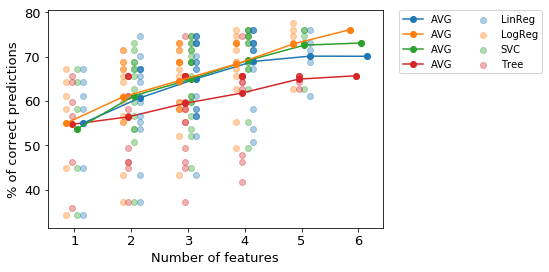

In [14]:
direc = '../input/features-and-models/'
LinReg_2016_FeatureAnalysis = pd.read_csv(direc+'ModelFeatureAnalysis_of_LinReg_1-6feat_2016.csv')
LinReg_2016_FeatureAnalysis['#Features'] = LinReg_2016_FeatureAnalysis['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
LogReg_2016_FeatureAnalysis = pd.read_csv(direc+'ModelFeatureAnalysis_of_LogReg_1-6feat_2016.csv')
LogReg_2016_FeatureAnalysis['#Features'] = LogReg_2016_FeatureAnalysis['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
Tree_2016_FeatureAnalysis = pd.read_csv(direc+'ModelFeatureAnalysis_of_Tree_1-6feat_2016.csv')
Tree_2016_FeatureAnalysis['#Features'] = Tree_2016_FeatureAnalysis['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
SVC_2016_FeatureAnalysis = pd.read_csv(direc+'ModelFeatureAnalysis_of_SVC_1-6feat_2016.csv')
SVC_2016_FeatureAnalysis['#Features'] = SVC_2016_FeatureAnalysis['Columns'].apply(lambda x: len(x.strip('[]').split(',')))

# Number of features vs WinsPred%
plt.scatter(LinReg_2016_FeatureAnalysis['#Features']+0.15, LinReg_2016_FeatureAnalysis['WinsPred%'], color='C0', alpha=0.35, label='LinReg', zorder=2)
plt.plot(LinReg_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['#Features']+0.15, 
            LinReg_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['WinsPred%'], 'o-',color='C0', label='AVG')

plt.scatter(LogReg_2016_FeatureAnalysis['#Features']-0.15, LogReg_2016_FeatureAnalysis['WinsPred%'], color='C1', alpha=0.35, label='LogReg')
plt.plot(LogReg_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['#Features']-0.15, 
            LogReg_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['WinsPred%'], 'o-',color='C1', label='AVG', zorder=4)

plt.scatter(SVC_2016_FeatureAnalysis['#Features']+0.05, SVC_2016_FeatureAnalysis['WinsPred%'], color='C2', alpha=0.35, label='SVC')
plt.plot(SVC_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['#Features']+0.05, 
            SVC_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['WinsPred%'], 'o-',color='C2', label='AVG', zorder=3)

plt.scatter(Tree_2016_FeatureAnalysis['#Features']-0.05, Tree_2016_FeatureAnalysis['WinsPred%'], color='C3', alpha=0.35, label='Tree')
plt.plot(Tree_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['#Features']-0.05, 
            Tree_2016_FeatureAnalysis.groupby(by=['#Features']).mean().reset_index()['WinsPred%'], 'o-',color='C3', label='AVG', zorder=1)


plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,  ncol=2)
plt.xlabel('Number of features', size=13)
plt.ylabel('% of correct predictions', size=13)
plt.tick_params(labelsize=13)
plt.savefig('NumberOfFeaturesvsWins.png', dpi=300, bbox_inches='tight')

### We can conclude that just simply adding features does not yield the best result. Some feature do worse then throwing a coin.

Text(0, 0.5, '% of correct predictions')

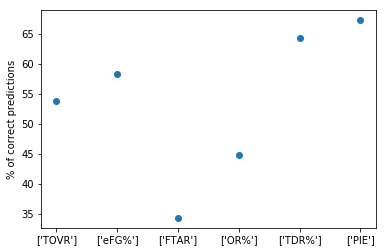

In [15]:
dummy = SVC_2016_FeatureAnalysis[SVC_2016_FeatureAnalysis['#Features'] == 1]
plt.scatter(dummy['Columns'], dummy['WinsPred%'])
plt.ylabel('% of correct predictions')

### We see that the Free Throw attempt rate 'FTAR' performs the poorest, follow by total defensive rebounds 'TDR%' and defensive rebounds 'OR%'.

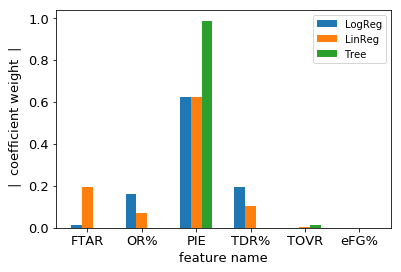

In [16]:
#plt.figure(figsize=(10,10))
Tree_6_Feature = Tree_2016_FeatureAnalysis[Tree_2016_FeatureAnalysis['#Features'] == 6]

def convert_strList_to_floats(df):
    if str(df) == str(Tree_6_Feature):
        dummy = list(map(lambda x: x[:5], df['Coef weight'][0][1:-1].split(' ')[0:-1]))
        return np.array(list(map(lambda x: float(x), [d for d in dummy if d != ''])))
    else:
        dummy = list(map(lambda x: x[:5], df['Coef weight'][0][1:-1].split(' ')[1:]))
        return np.array(list(map(lambda x: float(x), [d for d in dummy if d != ''])))

LogReg_6_Feature = LogReg_2016_FeatureAnalysis[LogReg_2016_FeatureAnalysis['#Features'] == 6]
yLog = convert_strList_to_floats(LogReg_6_Feature)/abs(convert_strList_to_floats(LogReg_6_Feature)).sum()
LinReg_6_Feature = LinReg_2016_FeatureAnalysis[LinReg_2016_FeatureAnalysis['#Features'] == 6]
yLin = convert_strList_to_floats(LinReg_6_Feature)/abs(convert_strList_to_floats(LinReg_6_Feature)).sum()
Tree_6_Feature = Tree_2016_FeatureAnalysis[Tree_2016_FeatureAnalysis['#Features'] == 6]
yTree= convert_strList_to_floats(Tree_6_Feature)/abs(convert_strList_to_floats(Tree_6_Feature)).sum()
plt.bar(np.arange(0, len(yLog),1)-0.2, abs(yLog), width=0.2, label='LogReg')
plt.bar(np.arange(0, len(yLin),1)+0.0, abs(yLin), width=0.2, label='LinReg')
plt.bar(np.arange(0, len(yTree),1)+0.2, abs(yTree), width=0.2, label='Tree')
plt.xlabel('feature name', size=13)
plt.ylabel('$\mid$ coefficient weight $\mid$', size=13)
plt.tick_params(labelsize=13)
featureList= list(map(lambda x: x[1:-1] ,LogReg_2016_FeatureAnalysis['Columns'][0][1:-1].split(', ')))
plt.xticks(range(0, len(featureList)),featureList)  # Set locations and labels
plt.legend()
plt.savefig('CoefficientWeight.png', dpa='1000')

In [17]:
LogReg_2016_FeatureAnalysis[LogReg_2016_FeatureAnalysis['#Features'] == 2]

,Season,Columns,WinsPred,GamesPlayed,WinsPred%,Score,C,Coef weight,#Features
42,2016,"['TOVR', 'eFG%']",41,67,61.2,-0.332756,3.072113e+02,[-0.2427595 31.58883838],2
43,2016,"['FTAR', 'TOVR']",29,67,43.3,-0.558251,9.547716e+00,[ 4.78002918 -0.14724575],2
44,2016,"['OR%', 'TOVR']",37,67,55.2,-0.610370,8.504489e+10,[ 4.76441456 -0.11507029],2
45,2016,"['TDR%', 'TOVR']",44,67,65.7,-0.247553,5.415871e+01,[30.58861216 -0.54572012],2
46,2016,"['PIE', 'TOVR']",48,67,71.6,-0.117023,3.872040e+12,[36.86396915 -0.1492847 ],2
47,2016,"['FTAR', 'eFG%']",37,67,55.2,-0.373604,3.072113e+02,[ 4.28960659 24.83199391],2
48,2016,"['OR%', 'eFG%']",40,67,59.7,-0.382747,3.072113e+02,[ 6.2167734 26.25766119],2
49,2016,"['TDR%', 'eFG%']",45,67,67.2,-0.401510,7.663411e+01,[ 5.82137328 18.81806253],2
50,2016,"['PIE', 'eFG%']",46,67,68.7,-0.127408,3.072113e+02,[35.79084454 -1.95998907],2
51,2016,"['FTAR', 'OR%']",25,67,37.3,-0.581219,9.547716e+00,[4.10369707 4.91485102],2


We find again that __['FTAR', 'OR%']__ have the lowest prediction percentage (just __37.3%!!__). 'TDR' sometimes performs well. Let's check what the best result has.

In [18]:
LogReg_2016_FeatureAnalysis[LogReg_2016_FeatureAnalysis['#Features'] == 5].sort_values(by=['WinsPred%'])

,Season,Columns,WinsPred,GamesPlayed,WinsPred%,Score,C,Coef weight,#Features
1,2016,"['FTAR', 'OR%', 'TDR%', 'TOVR', 'eFG%']",42,67,62.7,-0.185736,2.171118e+02,[ 4.71178163 0.83372529 21.7891919 -0.574443...,5
3,2016,"['FTAR', 'PIE', 'TDR%', 'TOVR', 'eFG%']",49,67,73.1,-0.115745,2.171118e+02,[ 0.23297294 33.33915275 2.83271426 -0.220802...,5
5,2016,"['FTAR', 'OR%', 'PIE', 'TDR%', 'TOVR']",49,67,73.1,-0.112282,1.499268e+10,[-0.42975027 5.65791047 41.24620472 -5.512861...,5
2,2016,"['FTAR', 'OR%', 'PIE', 'TOVR', 'eFG%']",50,67,74.6,-0.109464,1.084366e+02,[ 0.75455947 6.02760272 33.52950415 -0.233520...,5
6,2016,"['FTAR', 'OR%', 'PIE', 'TDR%', 'eFG%']",51,67,76.1,-0.106301,2.171118e+02,[ 0.63044746 11.34080265 42.05708932 -16.75...,5
4,2016,"['OR%', 'PIE', 'TDR%', 'TOVR', 'eFG%']",52,67,77.6,-0.105512,2.171118e+02,[ 9.99455931 40.4079143 -12.11825485 -0.07...,5


 __'OR%', 'PIE','eFG%', 'TOVR__' are always at the top __'OR%','TDR%' and 'FTAR'__ seem to be at the bottom.

##  Train and evaluate different models for different years (fixed features)

In [19]:
# This cell was run offline
## Train and evalute models for different seasons
#for model in ['LinReg','LogReg','DecTree','SVC']: # 'LinReg','LogReg','DecTree','SVC'
#    df_stats = pd.DataFrame(columns=['Season', 'Columns', 'WinsPred', 'GamesPlayed', 'WinsPred%', 'Coef weight', 'Score', 'C'])
#    counter = 0
#    columns = ['OR%', 'PIE', 'TOVR', 'eFG%'] # PIE', 'OR%', 'TOVR', 'eFG%'
#    for year in range(2003,2019):
#        print model
#        df_final = load_and_construct_features_in_df(year)   
#        year, columns, numOfWins, gamesPlayed, numOfWinsPerc, score, C, clf= main(df_final, columns=columns, year=year, model=model)
#        df_stats.at[counter,'Season'] = year
#        df_stats.at[counter,'Columns'] = columns
#        df_stats.at[counter,'WinsPred'] = numOfWins
#        df_stats.at[counter,'GamesPlayed'] = gamesPlayed
#        df_stats.at[counter,'WinsPred%'] = numOfWinsPerc
#        df_stats.at[counter,'Score'] = score
#        df_stats.at[counter,'C'] = C
#        if model == 'SVC':
#            df_stats.at[counter,'Coef weight'] = 0
#        elif model == 'DecTree':
#            df_stats.at[counter,'Coef weight'] = clf.best_estimator_.feature_importances_ 
#        elif model == 'LogReg':
#            df_stats.at[counter,'Coef weight'] = clf.best_estimator_.coef_[0]
#        elif model == 'LinReg':
#            df_stats.at[counter,'Coef weight'] = clf.best_estimator_.coef_
#        counter += 1
#    print df_stats
#    df_stats.to_csv('ModelAnalysis_of_'+str(model)+'_2003_2018_4features.csv', index=False)

## Compare models from years 2003 to 2018 based on 6 features ['FTAR', 'OR%', 'PIE', 'TDR%', 'TOVR', 'eFG%']

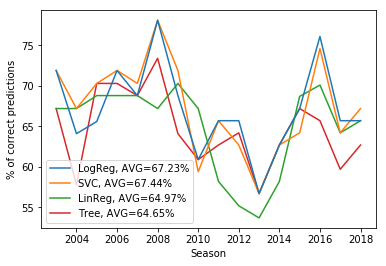

In [20]:
#plt.figure(figsize=(8,8))
direc = '../input/features-and-models/'
Lin_reg_2003_2018 = pd.read_csv(direc+'ModelAnalysis_of_LinReg_2003_2018_6features.csv')
Lin_reg_2003_2018['#Features'] = Lin_reg_2003_2018['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
LogReg_2003_2018 = pd.read_csv(direc+'ModelAnalysis_of_LogReg_2003_2018_6features.csv')
LogReg_2003_2018['#Features'] = LogReg_2003_2018['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
SVCReg_2003_2018 = pd.read_csv(direc+'ModelAnalysis_of_SVCReg_2003_2018_6features.csv')
SVCReg_2003_2018['#Features'] = SVCReg_2003_2018['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
TreeReg_2003_2018 = pd.read_csv(direc+'ModelAnalysis_of_DecTree_2003_2018_6features.csv')
TreeReg_2003_2018['#Features'] = TreeReg_2003_2018['Columns'].apply(lambda x: len(x.strip('[]').split(',')))

plt.plot(LogReg_2003_2018['Season'], LogReg_2003_2018['WinsPred%'], zorder=4, label='LogReg, AVG='+str(round(LogReg_2003_2018['WinsPred%'].mean(),2))+'%')
plt.plot(SVCReg_2003_2018['Season'], SVCReg_2003_2018['WinsPred%'], zorder=3, label='SVC, AVG='+str(round(SVCReg_2003_2018['WinsPred%'].mean(),2))+'%')
plt.plot(Lin_reg_2003_2018['Season'], Lin_reg_2003_2018['WinsPred%'], zorder=2, label='LinReg, AVG='+str(round(Lin_reg_2003_2018['WinsPred%'].mean(),2))+'%')
plt.plot(TreeReg_2003_2018['Season'], TreeReg_2003_2018['WinsPred%'], zorder=1, label='Tree, AVG='+str(round(TreeReg_2003_2018['WinsPred%'].mean(),2))+'%')
plt.xlabel('Season')
plt.ylabel('% of correct predictions')
plt.legend()
plt.savefig('ModelsCompared6features.png')

## Compare models from years 2003 to 2018 based on 5 features ['FTAR', 'PIE', 'TDR%', 'TOVR', 'eFG%']

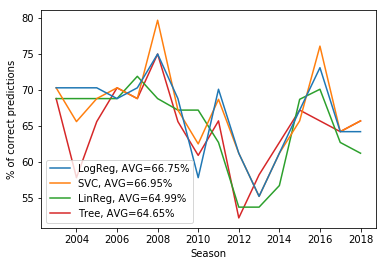

In [21]:
#plt.figure(figsize=(10,10))
direc = '../input/features-and-models/'
Lin_reg_2003_2018noOR = pd.read_csv(direc+'ModelAnalysis_of_LinReg_2003_2018_5features_noOR.csv')
Lin_reg_2003_2018noOR['#Features'] = Lin_reg_2003_2018noOR['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
LogReg_2003_2018noOR = pd.read_csv(direc+'ModelAnalysis_of_LogReg_2003_2018_5features_noOR.csv')
LogReg_2003_2018noOR['#Features'] = LogReg_2003_2018noOR['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
SVCReg_2003_2018noOR = pd.read_csv(direc+'ModelAnalysis_of_SVC_2003_2018_5features_noOR.csv')
SVCReg_2003_2018noOR['#Features'] = SVCReg_2003_2018noOR['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
TreeReg_2003_2018noOR = pd.read_csv(direc+'ModelAnalysis_of_DecTree_2003_2018_5features_noOR.csv')
TreeReg_2003_2018noOR['#Features'] = TreeReg_2003_2018noOR['Columns'].apply(lambda x: len(x.strip('[]').split(',')))

plt.plot(LogReg_2003_2018noOR['Season'], LogReg_2003_2018noOR['WinsPred%'], zorder=4, label='LogReg, AVG='+str(round(LogReg_2003_2018noOR['WinsPred%'].mean(),2))+'%')
plt.plot(SVCReg_2003_2018noOR['Season'], SVCReg_2003_2018noOR['WinsPred%'], zorder=3, label='SVC, AVG='+str(round(SVCReg_2003_2018noOR['WinsPred%'].mean(),2))+'%')
plt.plot(Lin_reg_2003_2018noOR['Season'], Lin_reg_2003_2018noOR['WinsPred%'], zorder=2, label='LinReg, AVG='+str(round(Lin_reg_2003_2018noOR['WinsPred%'].mean(),2))+'%')
plt.plot(TreeReg_2003_2018noOR['Season'], TreeReg_2003_2018noOR['WinsPred%'], zorder=1, label='Tree, AVG='+str(round(TreeReg_2003_2018noOR['WinsPred%'].mean(),2))+'%')
plt.xlabel('Season')
plt.ylabel('% of correct predictions')
plt.legend()
plt.savefig('ModelsCompared5featuresNoOR%.png')

## Compare models from years 2003 to 2018 based on 4 features ['OR%', 'PIE', 'TOVR', 'eFG%']

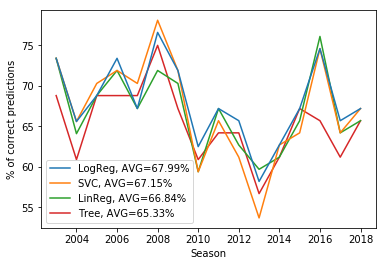

In [22]:
direc = '../input/features-and-models/'
Lin_reg_2003_2018_4feat = pd.read_csv(direc+'ModelAnalysis_of_LinReg_2003_2018_4features.csv')
Lin_reg_2003_2018_4feat['#Features'] = Lin_reg_2003_2018_4feat['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
LogReg_2003_2018_4feat = pd.read_csv(direc+'ModelAnalysis_of_LogReg_2003_2018_4features.csv')
LogReg_2003_2018_4feat['#Features'] = LogReg_2003_2018_4feat['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
SVCReg_2003_2018_4feat = pd.read_csv(direc+'ModelAnalysis_of_SVC_2003_2018_4features.csv')
SVCReg_2003_2018_4feat['#Features'] = SVCReg_2003_2018_4feat['Columns'].apply(lambda x: len(x.strip('[]').split(',')))
TreeReg_2003_2018_4feat = pd.read_csv(direc+'ModelAnalysis_of_DecTree_2003_2018_4features.csv')
TreeReg_2003_2018_4feat['#Features'] = TreeReg_2003_2018_4feat['Columns'].apply(lambda x: len(x.strip('[]').split(',')))

plt.plot(LogReg_2003_2018_4feat['Season'], LogReg_2003_2018_4feat['WinsPred%'], zorder=4, label='LogReg, AVG='+str(round(LogReg_2003_2018_4feat['WinsPred%'].mean(),2))+'%')
plt.plot(SVCReg_2003_2018_4feat['Season'], SVCReg_2003_2018_4feat['WinsPred%'], zorder=3, label='SVC, AVG='+str(round(SVCReg_2003_2018_4feat['WinsPred%'].mean(),2))+'%')
plt.plot(Lin_reg_2003_2018_4feat['Season'], Lin_reg_2003_2018_4feat['WinsPred%'], zorder=2, label='LinReg, AVG='+str(round(Lin_reg_2003_2018_4feat['WinsPred%'].mean(),2))+'%')
plt.plot(TreeReg_2003_2018_4feat['Season'], TreeReg_2003_2018_4feat['WinsPred%'], zorder=1, label='Tree, AVG='+str(round(TreeReg_2003_2018_4feat['WinsPred%'].mean(),2))+'%')
plt.xlabel('Season')
plt.ylabel('% of correct predictions')
plt.legend()
plt.savefig('ModelsCompared4features.png')

### Takeaways
#### + Feature visualization reveals correlations
#### + Data over the years can be noisy and fluctuate
#### + Models can perform similarly
#### + Features matter more than models!
#### + Reducing the number of features can result in better averaged results.


# Context of results
- Lower bound: Coin toss 50%
- Our results: ≈68% (averaged)
- Upper glass sealing**: ≈74-78% for sports predictions in general
                        (NBA ≈ 72-74%)
                        (Experts ≈ 68%)

Room for improvement:
- Use expert ratings/ranking, elo scoring system, etc…



**A. Zimmermann, S. Moorthy, Z. Shi, Predicting college basketball match outcomes using machine learning techniques: some results and lessons learned.  [CoRRabs/1310.3607](https://dblp.org/db/journals/corr/corr1310.html), (2013).
